In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/hillock_club_senescence')

import numpy as np
import pandas as pd
import anndata as ad

from pydeseq2 import dds


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-l_i033eu because the default path (/run/cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
def extract_gene_lengths_from_gtf(file_path):
    gene_lengths = {}

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue
            data = line.strip().split('\t')
            if data[2] == 'gene':
                attributes = data[8].split(';')
                gene_name = [x.split('"')[1] for x in attributes if 'gene_name' in x][0]
                start = int(data[3])
                end = int(data[4])
                length = end - start + 1
                gene_lengths[gene_name] = length

    return gene_lengths


In [157]:
dat = pd.read_csv('./data/dahl_2020/GSE142706_igenomes_known_GENES_counts.tab',sep='\t',index_col=0)

# Remove all genes with less than 5 total counts per sample
dat = dat[~(dat.sum(axis=1) < 10*(dat.shape[1]))]


In [159]:
# Extract gene lengths from the GTF file
gtf_file_path = '../prostate_spatial/gencode.v43.annotation.gtf'
gene_lengths = extract_gene_lengths_from_gtf(gtf_file_path)

# Subset the pseudobulk data to only contain those genes that have annotation
dat = dat[dat.index.isin(gene_lengths.keys())]

# Map the gene lengts to pseudobulk genes 
gene_length_mapping = dat.index.map(gene_lengths).tolist()

# Transform gene lenghts to kilobase
gene_length_mapping = np.array(gene_length_mapping,dtype=float)/1e3

# Function to calculate TPM
def calculate_tpm(df,gene_lengths_per_kb=gene_length_mapping):

    # Gene reads per kilobase
    df_rpk = df.divide(gene_lengths_per_kb,axis=0)

    # Total rpk per sample 
    sample_scaling_factor = df_rpk.sum()/1e6

    # TPM
    tpm_df = df_rpk.divide(sample_scaling_factor)

    return tpm_df



In [160]:

# Perform TPM normalization
tpm_normalized_dat = calculate_tpm(dat)

# Modify the counts and subet categories
categories = list(np.repeat('LNCaP',3)) + list(np.repeat('IL1a_LNCaP',3)) + list(np.repeat('IL1b_LNCaP',3))

# Add pseudocount and log2-transform
log2_tpm_normalized_dat = np.log2(tpm_normalized_dat +1 )


In [161]:

# Construct the DESeq2 dataset
adata = ad.AnnData(dat.T.values,
           var=pd.DataFrame(index=dat.index),
           obs=pd.DataFrame({'condition':categories},index=dat.columns,)
           )


deseq_dataset = dds.DeseqDataSet(adata=adata,design_factors='condition', ref_level=['condition','LNCaP'])

# Run the DESeq2 analysis
deseq_dataset.deseq2()


/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/pydeseq2/dds.py:250: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 10.47 seconds.

Fitting dispersion trend curve...
... done in 0.68 seconds.

Fitting MAP dispersions...
... done in 11.19 seconds.

Fitting LFCs...
... done in 1.31 seconds.

Refitting 0 outliers.



### Extract the DE results

In [162]:
from pydeseq2.ds import DeseqStats
from pydeseq2.default_inference import DefaultInference

### IL1a DEG results

In [307]:
# Define the inference
inference = DefaultInference(n_cpus=2)


il1a_deg_res = DeseqStats(deseq_dataset, contrast=["condition", 'IL1a-LNCaP', 'LNCaP'], inference=inference)
il1a_deg_res.summary()
il1a_deg_res = il1a_deg_res.results_df

# Get the significant results
il1a_deg_res_signinf = il1a_deg_res[(np.abs(il1a_deg_res['log2FoldChange']) >=1) & (il1a_deg_res['padj'] < 0.05)].sort_values('log2FoldChange',ascending=False)

Running Wald tests...


Log2 fold change & Wald test p-value: condition IL1a-LNCaP vs LNCaP
              baseMean  log2FoldChange     lfcSE       stat         pvalue  \
GENE_NAME                                                                    
WASH7P       43.085770        0.050237  0.215580   0.233033   8.157355e-01   
LINC00115    43.430775        0.338309  0.199212   1.698239   8.946271e-02   
SAMD11      276.250183       -0.453266  0.071691  -6.322527   2.573194e-10   
NOC2L      8234.986328       -0.238334  0.021812 -10.926674   8.594107e-28   
KLHL17     1442.934937        1.399963  0.040322  34.719202  4.043310e-264   
...                ...             ...       ...        ...            ...   
UTY         241.101395      -11.659274  1.942138  -6.003318   1.933251e-09   
NLGN4Y       90.342079      -10.242968  1.942476  -5.273151   1.341015e-07   
CD24        744.473450        1.424479  0.056515  25.205512  3.485382e-140   
KDM5D       547.606812      -12.842610  1.942025  -6.613000   3.766076e-11

... done in 4.72 seconds.



### Chronic IL1b DEG results

In [308]:
# Define the inference
inference = DefaultInference(n_cpus=2)

il1b_deg_res = DeseqStats(deseq_dataset, contrast=["condition", 'IL1b-LNCaP', 'LNCaP'], inference=inference)
il1b_deg_res.summary()
il1b_deg_res = il1b_deg_res.results_df

# Get the significant results
il1b_deg_res_signinf = il1b_deg_res[(np.abs(il1b_deg_res['log2FoldChange']) >=1) & (il1b_deg_res['padj'] < 0.05)].sort_values('log2FoldChange',ascending=False) 

Running Wald tests...


Log2 fold change & Wald test p-value: condition IL1b-LNCaP vs LNCaP
              baseMean  log2FoldChange     lfcSE       stat        pvalue  \
GENE_NAME                                                                   
WASH7P       43.085770        0.028943  0.207589   0.139426  8.891138e-01   
LINC00115    43.430775        0.376131  0.189404   1.985866  4.704825e-02   
SAMD11      276.250183       -0.424028  0.066602  -6.366613  1.932478e-10   
NOC2L      8234.986328        0.298092  0.020526  14.522920  8.673530e-48   
KLHL17     1442.934937        1.982446  0.037005  53.572147  0.000000e+00   
...                ...             ...       ...        ...           ...   
UTY         241.101395      -11.958552  1.941441  -6.159627  7.291669e-10   
NLGN4Y       90.342079      -10.542246  1.941779  -5.429169  5.661702e-08   
CD24        744.473450        1.048043  0.056905  18.417405  9.526250e-76   
KDM5D       547.606812      -13.141888  1.941328  -6.769537  1.291953e-11   
EIF1AY  

... done in 2.46 seconds.



### Calculate enrichment

In [247]:
gene_set_df = pd.read_excel('../club_scrnaseq/custom_gene_lists.xlsx',header=None).drop(columns=0).set_index(1).T

def load_from_pickle(filename):
    import pickle
    with open(filename, 'rb') as handle:
        obj = pickle.load(handle)
    return obj


def check_top_markers(r,p_thresh=0.05):
    # These results rank the deg significance and specificity (low p-value = good marker)
    deg_fishers_res_dict = load_from_pickle('/lustre/scratch/kiviaho/prostate_spatial/data/region_gene_markers_fishers_exact_test_240229.pkl')

    fishers_test_df = deg_fishers_res_dict[r].rename(columns={'interaction':'gene','active_in':'deg in'})
    fishers_test_df = fishers_test_df.sort_values('adj_pval').reset_index(drop=True)
    fishers_test_df = fishers_test_df[fishers_test_df['adj_pval'] < p_thresh]

    return fishers_test_df

gene_modules_dict = {
    'scNMF senescent epithelium':gene_set_df['sensescent epithelium'].dropna().tolist(),
    'scNMF club_interferon epithelium': ['HLA-DRA','CD74','HLA-DRB1','HLA-DPA1','HLA-DQB1','HLA-DMA','CP','LXN','HLA-DPB1','HLA-B','MMP7','C3','HLA-A','HLA-DRB5','SCUBE2','HLA-DQA1','PDZK1IP1','LTF','SOD2','TGM2','PIGR','MGP','TNFAIP2','RARRES3','C1S','C1R','SAA1','CLU','SELENBP1','BIRC3','CXCL2','SLC40A1','FAM3D','SERPING1','HLA-DMB','CFTR','HLA-F','NNMT','IFITM3','SLFN5','CD59'],
    'AR signaling':gene_set_df['AR signaling'].dropna().tolist(),
    'Tumor region markers': check_top_markers('Tumor')['gene'].tolist(),
    'Luminal region markers': check_top_markers('Luminal epithelium')['gene'].tolist(),
    'Basal region markers': check_top_markers('Basal epithelium')['gene'].tolist(),
    'Club region markers': check_top_markers('Club epithelium')['gene'].tolist(),
    'Club Henry et al. 2018': ['SCGB3A1','LCN2','PIGR','PSCA','OLFM4','RARRES1','SPINK1','CD74','S100P','WFDC2','FCGBP','GDF15','AGR2','HLA-DRA','PI3','FAM3D','SLPI','C15orf48','TXNIP','DUOXA2','ANKRD36C','CXCL17','TMSB4X','ADGRF1','VSIG2','HLA-DRB1','TFF1','CRABP2','CLDN3','ASS1','RHOV','CEACAM6','B2M','CP','TMEM45B','SRD5A3','PDZK1IP1','AGR3','CEACAM5','BIK','LINC01207','HLA-DRB5','SCCPDH','MMP7','ZG16B','TSPAN3','ELF3','NEAT1','S100A6','AZGP1','PPDPF','MAL2','FOXO3','RAB11FIP1','CYP3A5','FTH1','REEP3','ADIRF','CXCL6','GPRC5A','GLUL','DUSP5','CD24','TMEM165','MGST1','HPGD','CYP1B1','SAA1','GPX2'],
    'Hillock Henry et al. 2018': ['KRT13','S100P','APOBEC3A','GDF15','CSTB','DUOXA2','OLFM4','GPX2','LYPD3','CXCL17','AKR1C1','SERPINB1','AKR1C2','IGFBP3','IL1RN','MUC4','SDCBP2','HPGD','ADIRF','CLDN4','DHRS9','TRIM31','GPRC5A','EMP1','C15orf48','SNCG','DUSP5','ADGRF1','RAB11FIP1','MGST1','TMSB4X','CLDN3','SDC1','TMPRSS4','MAL2','C9orf16','ASS1','PIM1','DAPP1','PPARG','CLDN7','HEBP2','ELF3','OAS1','AQP3','OAF','CLCA4','CDKN2B','PSCA','PLAUR','S100A9','DDIT4','CCL20','AREG'],
    'Club-like senescence': ['AGR2','AQP3','CLDN4','CLDN7','CRABP2','CXCL17','ELF3','GPRC5A','IGFBP3','KRT13','KRT16','KRT17','KRT7','LCN2','MAL2','MUC4','PDZK1IP1','PI3','PRSS22','S100A9','S100P','SAA1','SERPINB1','SLPI','TACSTD2','WFDC2'],
    'IL1A_IL1B_prostate': ['IL1A', 'PTGS2', 'IL1B', 'CXCL3', 'TNFAIP3', 'IER3', 'CCL3', 'NFKBIZ', 'NFKBIA', 'CXCL2', 'SOD2', 'LUCAT1', 'PLEK', 'CCL20', 'KYNU', 'G0S2', 'NAMPT', 'PNRC1', 'PPIF', 'BCL2A1', 'CD93', 'EREG', 'NLRP3', 'THBS1', 'AQP9', 'CD55', 'ACSL1', 'FNDC3B', 'TREM1', 'C5AR1', 'ELL2', 'CD44', 'DUSP6', 'AREG', 'WTAP', 'TNFAIP6', 'B4GALT5', 'GCH1', 'IL1RN', 'MXD1', 'ATP2B1', 'ATP13A3', 'EHD1', 'CXCL1', 'SLC25A37', 'SAMSN1', 'OLR1', 'ZEB2', 'EAF1', 'RNF19B', 'THBD', 'OTUD1', 'CXCL8', 'ANPEP', 'SERPINB2', 'TIMP1', 'CCL4', 'CCL3L1', 'SAV1', 'BTG1', 'S100A8', 'SRGN', 'ICAM1', 'GK', 'FCN1', 'VCAN', 'RASGEF1B', 'MARCKS', 'S100A9', 'SLC11A1', 'NEAT1'],
    'JAK_STAT_FGFR': ['IRF9','STAT1','STAT2','CCND3','STAT3','IL13RA1','IL11RA1','AKT3','SPRED1','IL10RB','CCND1','PIK3R1','SOCS2','SPRY1','JAK1','PIK3R2','IFNAR1','STAM','STAT5B','PIAS2','AKT2','PTPN11','STAT5A','JUN','CXCL10','CD44','CXCL2','TNF','CD14','TNFRSF1B','BAK1','IRF1','CSF1','FGF1','FGF10','FGF17','FGF18','FGF19','FGF2','FGF20','FGF22','FGF23','FGF3','FGF4','FGF5','FGF6','FGF7','FGF8','FGF9','FGFR1','DUSP6','TGIF','SMAD3','SMAD2','THBS1','FOS','TGFBR2','SOX9','TGFB1','FKBP1A','MMP15','FGFR2','FGFR3'],
    'JAK_STAT_ACTIVATORS_LIGANDS':["IFNA", "IFNB", "IFNG", "IGF1", "EGF", "PDGF", "CSF1", "KITLG", "FGF1", "FGF2", "FGF10", "FGF9", "BDNF", "VEGF", "HGF", "GH", "TPO", "EPO","PRL", "IL3", "IL5", "IL2", "IL4", "IL6", "LIF", "IL7", "IL9", "IL13","IL15", "IL21", "IL11", "CTF1", "OSM", "CSF3", "LEP", "IL31", "CNTF","IL10", "IL19", "IL20", "IL22", "IL24", "IL26", "IL28A", "IL28B", "IL29","IL12", "IL23", "IL27", "AGT", "F2", "BDK", "PTAF", "CXCL12", "CCL2","CCL5", "CCL15"],
    'JAK_STAT_ACTIVATORS_RECEPTORS':['IFNAR2','IFNBR2','IFNGR2','IGF1R','EGFR','PDGFR','CSF1R','KIT','FGFR1','FGFR2','FGFR3','FGFR4','FGFR1','FGFR2','FGFR3','FGFR4','FGFR1','FGFR2','FGFR3','FGFR4','FGFR1','FGFR2','FGFR3','FGFR4','NTRK2','VEGFR1','VEGFR2','VEGFR4','MET','GHR','TPOR','EPOR','PRLR','IL3RA','IL5RA','IL2RA','IL4RA','IL6RA','IL6ST','LIFR','IL7RA','IL9RA','IL13RA','IL15RA','IL21RA','IL11RA','CTF1R','OSMR','CSF3R','LEPR','IL31RA','CNTFR','IL10RA','IL19RA','IL20RA','IL22RA','IL12RA','IL12RA','IL12RA','IL12RA','IL12RA','IL12RA','IL23RA','IL27RA','AGTR','F2RL1','F2RL2','F2RL3','BDKRB2','PTAFR','CXCR4','CCR2','CCR5','CCR1'],
    'PDAC T cells': ['LTB','CD2','IL7R','SPOCK2','CCR6','TRAC','ICOS','TRBC1','KLRB1','CD3D','TRBC2','GPR171','CD3E','CCR7','ITK','CD3G','CLEC2D','P2RY10','LCK','BICDL1','GIMAP7','CYTIP','SC5D','LEPROTL1','RCAN3','GNLY','NKG7','CCL5','GZMB','GZMA','KLRD1','PRF1','GZMH','GZMK','CTSW','XCL2','CD8A','GZMM','CST7','CCL4','LINC01871','CD7','CD247','CD96','SH2D2A','SYTL3','APOBEC3G','RUNX3','ARHGAP9','PTPN22'],
    'NK cells': ['NKG7','GNLY','CD8A'],
    'PDAC Macrophages': ['APOC1','C1QB','APOE','C1QC','C1QA','SPP1','CCL3L1','CCL3','TREM2','MSR1','GPNMB','MS4A7','SLCO2B1','FCGR3A','FCGR2A','MS4A4A','SLC16A10','CD14','CSF1R','RNASE1','CD68','SDS','VSIG4','MRC1','CYBB'],
    'PDAC Neutrophils': ['S100A8','CXCL8','FCGR3B','IL1R2','S100A12','PROK2','NAMPT','CSF3R','CMTM2','S100A9','BCL2A1','AC245128.3','ADGRG3','IFITM2','AL034397.3','SAMSN1','IVNS1ABP','AQP9','PTGS2','GCA','BASP1','G0S2','FPR1','PLEK','PHACTR1','FPR2','LITAF','ANP32A','ACSL1','MNDA','RIPOR2','NCF1','ALOX5AP','CPD','SMIM25','TREM1','IRAK3','SRGN','RNF149','NABP1','LST1','NSMAF','LCP1','MME','SLA','SELL','CXCR2','LCP2','HCAR2','C5AR1'],
    'PDAC Monocytes': ['S100A8','FCN1','S100A9','S100A12','SERPINB2','EREG','CD300E','AC245128.3','APOBEC3A','NLRP3','SLC11A1','AQP9','THBS1','FPR1','MCEMP1','C5AR1','IL1B','SMIM25','ATP2B1-AS1','CSF3R','SLC43A2','CFP','IL1R2','THBD','FPR2'],
    'PDAC Dendritic cells': ['CEBPB','IL10','NOS2','RORC','S100A8','SOCS1','SOCS3','TGFB1','IL6','CSF2','CSF1','FLT3LG','ARG1','PTGS2','VEGFA','TNF','S100A9','CYBB','NCF1','NCF4','CSF3R','CXCL8','MNDA','LYZ','NCF2','SELL','ICAM1','CD63','CD274','OLR1'],
    'PMN-MDSC activity': ['RPL21','XAF1','CLEC5A','CAMP','CD63','LTF','ANXA3','S100A8','OAS2','ALOX5','IFIT1','CD177','S100A9','CEBPE','LCN2','ANXA1','CTSG','MPO','GSTM1','MEGF9','PYGL','PRTN3','YTHDF3','EMILIN1','ELANE','CHI3L1','LTA4H','VILL','HMGN2','C3','MS4A3','ITGAM','CLEC12A','CST7','HSD11B1','C5AR1','F13A1','ADPGK','HP','IDH1','DHRS7','PGLYRP1','MMP9','ALDH3B1','IGSF6','CYBB','AP3S1','NKG7','RAB31','MSRA','OAS3','SLPI','SYNE1','MECR','PRDX5','MCFD2','RAB3D','PILRA','SCP2','ALAS1','CPNE3','NCF1','MAPKAPK3','ACOT7','CD9','IFITM3','MMP8','PLAC8','NAMPT','ZMPSTE24','ARHGDIB','LGALS1','PADI4','ENO1','DSTN','IFI27L1','MYO1F','ETHE1','CEACAM1','SH3BGRL3','GSN']
}

# Test the function
[print(f'{k}: {len(gene_modules_dict[k])}') for k in list(gene_modules_dict.keys())]

#### REMOVE THE OVERLAPS BETWEEN GENE SIGNARTURES TO ENSURE AN UNBIASED CORRELATION ANALYSIS ####
#gene_modules_dict = remove_overlaps(gene_modules_dict)
print('')
[print(f'{k}: {len(gene_modules_dict[k])}') for k in list(gene_modules_dict.keys())]

scNMF senescent epithelium: 90
scNMF club_interferon epithelium: 41
AR signaling: 20
Tumor region markers: 569
Luminal region markers: 1776
Basal region markers: 46
Club region markers: 452
Club Henry et al. 2018: 69
Hillock Henry et al. 2018: 54
Club-like senescence: 26
IL1A_IL1B_prostate: 71
JAK_STAT_FGFR: 63
JAK_STAT_ACTIVATORS_LIGANDS: 57
JAK_STAT_ACTIVATORS_RECEPTORS: 74
PDAC T cells: 50
NK cells: 3
PDAC Macrophages: 25
PDAC Neutrophils: 50
PDAC Monocytes: 25
PDAC Dendritic cells: 30
PMN-MDSC activity: 81

scNMF senescent epithelium: 90
scNMF club_interferon epithelium: 41
AR signaling: 20
Tumor region markers: 569
Luminal region markers: 1776
Basal region markers: 46
Club region markers: 452
Club Henry et al. 2018: 69
Hillock Henry et al. 2018: 54
Club-like senescence: 26
IL1A_IL1B_prostate: 71
JAK_STAT_FGFR: 63
JAK_STAT_ACTIVATORS_LIGANDS: 57
JAK_STAT_ACTIVATORS_RECEPTORS: 74
PDAC T cells: 50
NK cells: 3
PDAC Macrophages: 25
PDAC Neutrophils: 50
PDAC Monocytes: 25
PDAC Dendritic

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [318]:

# Add the upregulated genes as gene signatures
gene_modules_dict['il1a_deg_res_up'] = il1a_deg_res_signinf[il1a_deg_res_signinf['log2FoldChange'] >= 1].index.tolist()
gene_modules_dict['il1b_deg_res_up'] = il1b_deg_res_signinf[il1b_deg_res_signinf['log2FoldChange'] >= 1].index.tolist()

gene_modules_dict['il1a_deg_res_down'] = il1a_deg_res_signinf[il1a_deg_res_signinf['log2FoldChange'] <= -1].index.tolist()
gene_modules_dict['il1b_deg_res_down'] = il1b_deg_res_signinf[il1b_deg_res_signinf['log2FoldChange'] <= -1].index.tolist()


In [329]:
gene_modules_dict.keys()

dict_keys(['scNMF senescent epithelium', 'scNMF club_interferon epithelium', 'AR signaling', 'Tumor region markers', 'Luminal region markers', 'Basal region markers', 'Club region markers', 'Club Henry et al. 2018', 'Hillock Henry et al. 2018', 'Club-like senescence', 'IL1A_IL1B_prostate', 'JAK_STAT_FGFR', 'JAK_STAT_ACTIVATORS_LIGANDS', 'JAK_STAT_ACTIVATORS_RECEPTORS', 'PDAC T cells', 'NK cells', 'PDAC Macrophages', 'PDAC Neutrophils', 'PDAC Monocytes', 'PDAC Dendritic cells', 'PMN-MDSC activity', 'il1a_deg_res_signinf', 'il1b_deg_res_signinf', 'il1a_deg_res_up', 'il1b_deg_res_up', 'il1a_deg_res_down', 'il1b_deg_res_down'])

In [357]:
from scipy.stats import fisher_exact


In [324]:
# Sanity check:
log2_tpm_normalized_dat.loc[overlap]

,LNCaP_1,LNCaP_2,LNCaP_3,LNas1_1,LNas1_2,LNas1_3,LNbs1_1,LNbs1_2,LNbs1_3
GENE_NAME,,,,,,,,,
SLFN5,3.357507,3.403663,3.412097,4.094773,4.256354,4.180975,1.964216,2.121681,1.985074
CLU,3.932245,4.028850,3.956660,1.855596,2.098202,2.023943,1.545322,1.511705,1.351757
PIGR,3.387912,3.564346,3.482087,4.128707,4.195871,4.154224,0.877788,0.796367,1.002335
FAM3D,0.124877,0.200150,0.196025,0.442041,0.413677,0.480587,0.069571,0.064202,0.111411
MMP7,3.615427,3.683419,3.630971,3.638564,3.580443,3.467473,0.993815,0.998885,0.918783
SELENBP1,8.185917,8.240927,8.150525,8.405751,8.565959,8.540581,7.498519,7.625429,7.661040
HLA-B,4.330076,4.371675,4.348360,5.116344,5.194357,5.135346,3.476078,3.607690,3.613736
BIRC3,3.935663,4.057612,3.944492,3.647804,3.963283,3.882725,1.506423,1.749883,1.657169
HLA-DQB1,2.331154,2.216773,2.212526,3.344455,3.564617,3.760584,0.629157,0.834524,0.719026


### Plot volcano plots

In [197]:
import seaborn as sns
from matplotlib import pyplot as plt

In [360]:
signature_name = 'Club region markers' # Club region markers, scNMF senescent epithelium, scNMF club_interferon epithelium
plot_df = il1a_deg_res.copy()

signatures = ['il1a_deg_res_up',signature_name] # Club region markers, scNMF senescent epithelium, scNMF club_interferon epithelium, 

fishers_df = pd.DataFrame(index = dat.index)
for sig_name in signatures:

    sig = gene_modules_dict[sig_name]
    sig = [g for g in sig if g in fishers_df.index.tolist()]

    #preface
    fishers_df[sig_name] = 'no'
    fishers_df.loc[sig,sig_name] = 'yes'

    fishers_df[sig_name] = pd.Categorical(fishers_df[sig_name],categories=['yes','no'])

fishers_df = pd.crosstab(fishers_df[signatures[0]],fishers_df[signatures[1]])

overlap = list(set(gene_modules_dict[signatures[0]]).intersection(set(gene_modules_dict[signatures[1]])))
print(overlap)
oddsratio, pval = fisher_exact(fishers_df)

print(fishers_df)
print(f'OR: {oddsratio:.2f}, p-value: {pval:.2e}')

['THSD4', 'TP53I3', 'MYOF', 'PABPC1L', 'MAFF', 'ICAM1', 'SAA2', 'SLPI', 'ST6GAL1', 'CYP4F12', 'S100P', 'PPL', 'INPP5J', 'RNF207', 'SAA1', 'ZC3H12A', 'TM4SF1', 'PLEKHA6', 'PTGES', 'KCNQ1', 'SLC26A4', 'NNMT', 'TPBG', 'ROBO1', 'IRX3', 'AQP3', 'NFKBIZ', 'SLC40A1', 'TMEM45A', 'TFCP2L1', 'CCL20', 'RUNX1', 'KLF5', 'PDE8B', 'ITGB4', 'DTX4', 'LYZ', 'PTGS2', 'PPP1R1B', 'VNN2', 'PRSS22', 'MUC4', 'TJP3', 'FCGBP', 'NFIB', 'SLC15A2', 'MUC1', 'CFB', 'CP', 'SLC44A4', 'C1RL', 'GABRE', 'SIRPA', 'DUSP4', 'SERPINA1', 'PLEKHS1', 'PI3', 'MUC20', 'TGM2', 'ZMIZ2', 'NPAS2', 'LCN2', 'HES1', 'RIN2', 'GSTA1', 'CDH3', 'GPX2', 'CLCF1', 'PDZK1IP1']
Club region markers  yes     no
il1a_deg_res_up                
yes                   69   1766
no                   270  10852
OR: 1.57, p-value: 1.53e-03


/home/ak431480/.conda/envs/squidpy/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


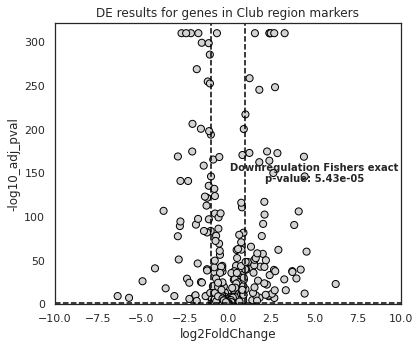

In [356]:

plot_df['-log10_adj_pval'] = -np.log10(plot_df['padj']) 

# Replace infs with the highest value = 310
plot_df.replace([np.inf, -np.inf], 310, inplace=True)

# Clip it at 50
clip_max = 320
plot_df['-log10_adj_pval'] = plot_df['-log10_adj_pval'].clip(0,clip_max)


gene_signature = gene_modules_dict[signature_name].copy()

plot_df = plot_df[plot_df.index.isin(gene_signature)]
plot_df['in_signature'] = 'no'

plot_df.loc[plot_df.index.isin(gene_signature),'in_signature'] = 'yes'

sns.set_theme(style='white', palette=sns.color_palette(['lightgray','#ffd92f']))


fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(data=plot_df,
                x='log2FoldChange',
                y='-log10_adj_pval',
                s=50,
                hue='in_signature',
                legend=False,
                linewidth=1,
                edgecolor='black',
                ax=ax)

ax.set_xlim(-10, 10)
ax.set_ylim(-0.5, clip_max+2)
ax.axhline(y=-np.log10(0.05), color='black', linestyle='--')
ax.axvline(x=-1, color='black', linestyle='--')
ax.axvline(x=1, color='black', linestyle='--')

ax.set_title(f'DE results for genes in {signature_name}')

if len(gene_modules_dict[signature_name]) < 100:
    # Adding gene name labels
    for i in range(len(plot_df)):
        if np.abs(plot_df['log2FoldChange'].iloc[i]) >= 1 and plot_df['padj'].iloc[i] < 0.05:
            ax.text(plot_df['log2FoldChange'].iloc[i], 
                    plot_df['-log10_adj_pval'].iloc[i], 
                    plot_df.index[i], 
                    fontsize=10, 
                    ha='left')

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.text(s=f'Downregulation Fishers exact\np-value: {pval:.2e}', x = 5, y = 150,ha='center',va='center',weight='bold',size=10)

plt.tight_layout()

#gene_set = col_name.replace(' ','_')
#plt.savefig(plot_save_path + f'{gene_set}_degs_volcano_plot.pdf')

plt.show()
